In [21]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from scipy import stats
# from sklearn.preprocessing import normalize
# from sklearn.metrics import confusion_matrix

## Author: Fengze Han; Yinan Shi

## Data  Loading 

In [22]:
json_data = json.loads(open ('scores.json').read())
dmos = pd.read_csv("DMOS_value.csv")
df = pd.DataFrame()
for _, name in enumerate(list(json_data.keys())):
    for _, rp in enumerate(list(json_data[name].keys())):
        d = dict(zip( list(json_data[name][rp].keys()), list(json_data[name][rp].values()) ))
        temp = pd.DataFrame(data = d, index = [name + '_' + rp])
        df = df.append(temp)

/Users/fengzehan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Data Preprocessing and Visualizing

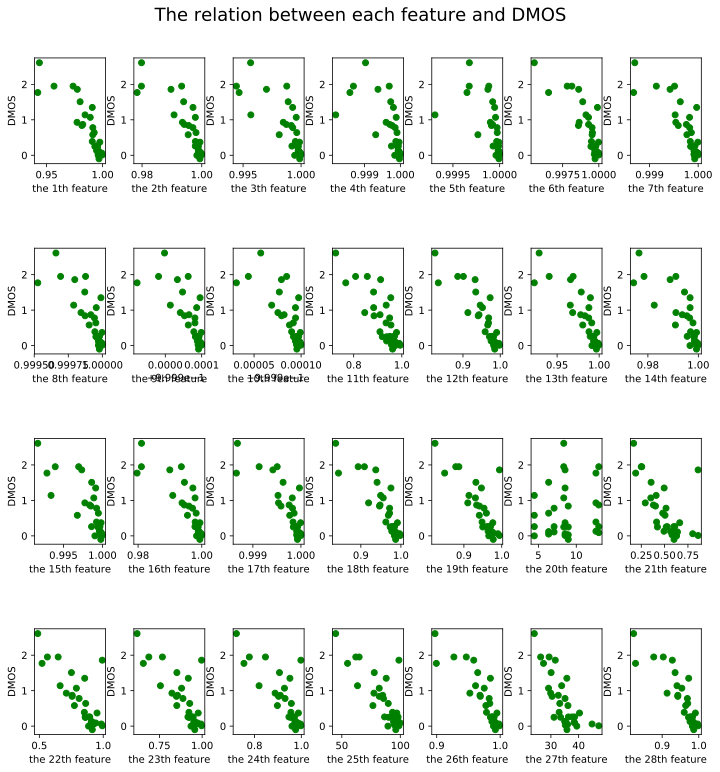

<Figure size 432x288 with 0 Axes>

In [23]:
df.drop(columns = 'method',inplace = True)
columns = pd.Series(df.columns)
column = columns.str.contains(r'NIQE*|BAGGING*|Phone*')
column = column[column == False].index
df1 = df.iloc[:,column]
# df1.shape
# plt.boxplot(df1,0, 'gD')
# print(df1.columns)
num_feature = df1.shape[1]
fig, ax = plt.subplots(nrows=4, ncols=7,figsize=(10,10))
fig.tight_layout() 
fig.suptitle('The relation between each feature and DMOS',fontsize=18,x=0.50,y=1.05)
plt.subplots_adjust(wspace =0.4, hspace =0.8)
i = 0
for row in ax:
    for col in row:
        col.plot(df1.iloc[:,i],dmos.iloc[:,2],"go")
        col.set_xlabel('the {}th feature'.format(i+1))
        col.set_ylabel('DMOS')
        i += 1
plt.show()
plt.savefig("Preprocessing")

Text(0.5,0,'8th feature ')

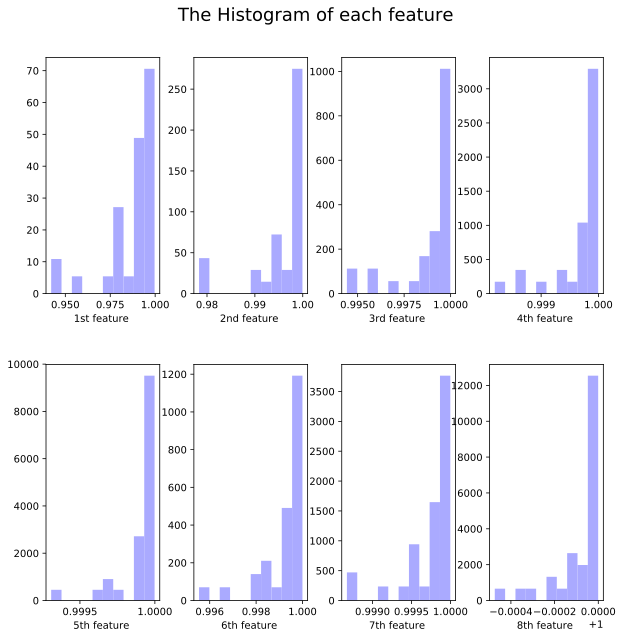

In [24]:
fig, ax = plt.subplots(2, 4, figsize=(10,10))
# fig.set_xlabel('common xlabel')
# fig.set_ylabel('common ylabel')

# bins = np.linspace(-5, 10, 10)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.suptitle('The Histogram of each feature',fontsize=18,x=0.50,y=0.95)
ax[0,0].hist(df1.iloc[:,0],density=True, fc='#AAAAFF')
ax[0,0].set_xlabel('1st feature ')
ax[0,1].hist(df1.iloc[:,1],density=True, fc='#AAAAFF')
ax[0,1].set_xlabel('2nd feature ')
ax[0,2].hist(df1.iloc[:,2],density=True, fc='#AAAAFF')
ax[0,2].set_xlabel('3rd feature ')
ax[0,3].hist(df1.iloc[:,3],density=True, fc='#AAAAFF')
ax[0,3].set_xlabel('4th feature ')
ax[1,0].hist(df1.iloc[:,4],density=True, fc='#AAAAFF')
ax[1,0].set_xlabel('5th feature ')
ax[1,1].hist(df1.iloc[:,5],density=True, fc='#AAAAFF')
ax[1,1].set_xlabel('6th feature ')
ax[1,2].hist(df1.iloc[:,6],density=True, fc='#AAAAFF')
ax[1,2].set_xlabel('7th feature ')
ax[1,3].hist(df1.iloc[:,7],density=True, fc='#AAAAFF')
ax[1,3].set_xlabel('8th feature ')
#     ax[0, 0].text(-3.5, 0.31, "Histogram")
# plt.hist(df1.iloc[:,1],density=True, fc='#AAAAFF')

## Standardization

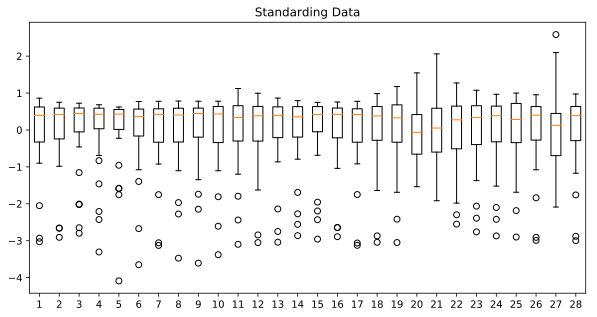

In [25]:
df1 -= df1.mean()
df1 /= df1.std()
plt.figure(figsize=(10,5))
plt.title('Standarding Data')
plt.boxplot(df1.T)
plt.show()
# df1

## Model: PLSR 

In [26]:
X = df1.iloc[:,0:28]
Y = dmos.iloc[:,2]
content = list(range(0,8))
# Content = np.array(['colour_boats','cow','crowdrun','elfuente','food_market','foxbird','people','seeking'])
groups = list(map(lambda x : [x] * 4, content)) 
groups = np.array(groups)
groups = groups.flatten()

In [27]:
loo = LeaveOneGroupOut()
loo.get_n_splits(X, Y, groups)
TestErrorPLS = np.zeros(20)
nsplits = 8

for n_components in list(range(1,21)):
    error_test_pls = 0
    
    for train_index, test_index in loo.split(X, Y, groups): 
        x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        x_train_mean, x_train_std = x_train.mean(), x_train.std()
#         map(lambda:x (x - x_train_mean)/x_train_std, [x_train, x_test])
        x_train = (x_train - x_train_mean)/x_train_std
        x_test = (x_test - x_train_mean)/x_train_std
        pls = PLSRegression(n_components)
        pls.fit(x_train,y_train)
        pls_y_pred_test = pls.predict(x_test)
        y_test = np.array(y_test)
        y_test = np.reshape(y_test,(4,1))
        error_test_pls += np.sum(np.square(pls_y_pred_test - y_test))

    avg_error_test_pls = np.sqrt(error_test_pls/(4*nsplits))
    TestErrorPLS[n_components-1] = avg_error_test_pls

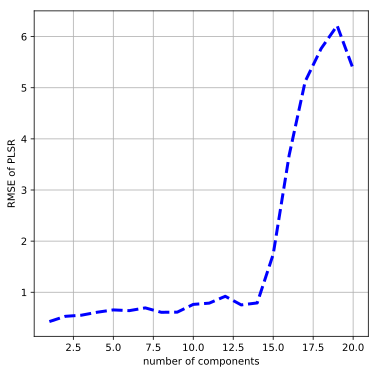

In [28]:
x = np.arange(1,21,1);
y = TestErrorPLS
plt.figure(figsize=(6,6))
plt.plot(x, y,'b--',linewidth=3.0)
plt.ylabel("RMSE of PLSR")
plt.xlabel('number of components')
plt.grid()
# plt.savefig("PLSRtest.pdf")


## Scatter Result of the model

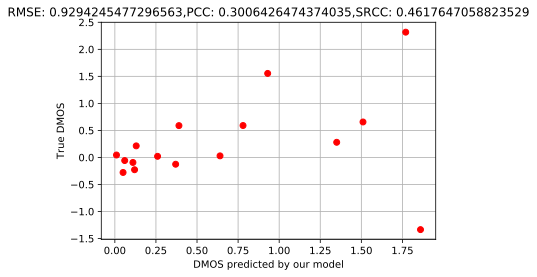

In [29]:
X_demo = df1.iloc[:16,0:28]
Y_demo = dmos.iloc[:16,2]
X_try = df1.iloc[16:,0:28]
Y_try = dmos.iloc[16:,2]
pls = PLSRegression(n_components = 10)
pls.fit(X_demo,Y_demo)
pls_predY = pls.predict(X_try)
Y_try = np.array(Y_try)
Y_try = np.reshape(Y_try,(16,1))
pls_rmse = np.sqrt(np.sum(np.square(pls_predY - Y_try))/16)
plt.ylabel("True DMOS")
plt.xlabel('DMOS predicted by our model')
plt.plot(Y_try, pls_predY,"ro")
pls_pcc = stats.pearsonr(Y_try, pls_predY)[0]
pls_srcc = stats.spearmanr(Y_try, pls_predY)[0]
plt.title('RMSE: {},PCC: {},SRCC: {}'.format(pls_rmse,float(pls_pcc),pls_srcc,fontsize=3,x=0.50,y=1.05))
plt.grid()
# plt.savefig("PLSRmodel_component10.pdf")

## Model:PCR

In [30]:
X = df1.iloc[:,0:28]
Y = dmos.iloc[:,2]
content = list(range(0,8))
# Content = np.array(['colour_boats','cow','crowdrun','elfuente','food_market','foxbird','people','seeking'])
groups = list(map(lambda x : [x] * 4, content)) 
groups = np.array(groups)
groups = groups.flatten()

In [31]:
loo = LeaveOneGroupOut()
loo.get_n_splits(X, Y, groups)
TestErrorPCR = np.zeros(20)
nsplits = 8

In [32]:
for n_components in list(range(1,21)):
    error_test_pcr = 0
    pca = PCA(n_components)
    lr = LinearRegression()
#     pipeline = Pipeline([('pca', pca),('regr',lr)])

    for train_index, test_index in loo.split(X, Y, groups): 
        x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        x_train_mean, x_train_std = x_train.mean(), x_train.std()
        x_train = (x_train - x_train_mean)/x_train_std
        x_test = (x_test - x_train_mean)/x_train_std
        model = lr.fit(pca.fit_transform(x_train), y_train)
        pcr_y_pred_test = model.predict(pca.transform(x_test))
#         pipe = pipeline.fit(pca.fit_transform(x_train),y_train)
#         pcr_y_pred_test = pipe.predict(pca.transform(x_test))
        y_test = np.array(y_test)
        y_test = np.reshape(y_test,(4,1))
        error_test_pcr += np.sum(np.square(pcr_y_pred_test - y_test))

    avg_error_test_pcr = np.sqrt(error_test_pcr/(4*nsplits))
    TestErrorPCR[n_components-1] = avg_error_test_pcr

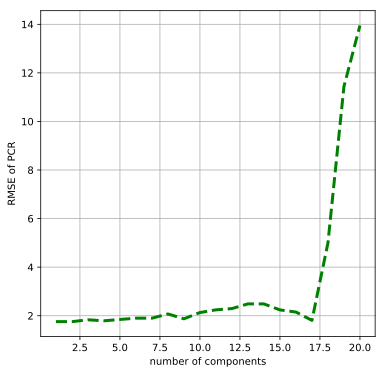

In [33]:
x = np.arange(1,21);
y = TestErrorPCR
plt.figure(figsize=(6,6))
plt.plot(x, y, 'g--',linewidth=3.0)
plt.ylabel("RMSE of PCR")
plt.xlabel('number of components')
plt.grid()
# plt.savefig("PCRtest.jpg")

## Comparison between PLSR and PCR

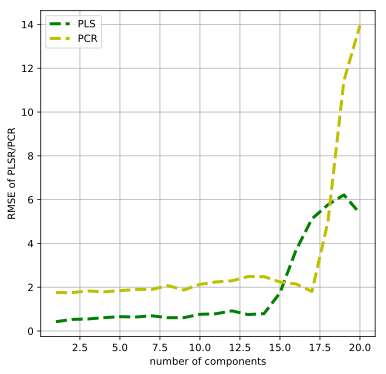

In [34]:
plt.figure(figsize=(6,6))
x = np.arange(1,21);
plt.ylabel("RMSE of PLSR/PCR")
plt.xlabel('number of components')
l1, = plt.plot(x, TestErrorPLS,'g--', linewidth=3.0)
l2, = plt.plot(x, TestErrorPCR, 'y--', linewidth=3.0)
plt.legend(handles = [l1, l2,], labels = ['PLS', 'PCR'], loc = 'best')
plt.grid()
# plt.savefig("Comparision.jpg")

## Scattering Result of the Model

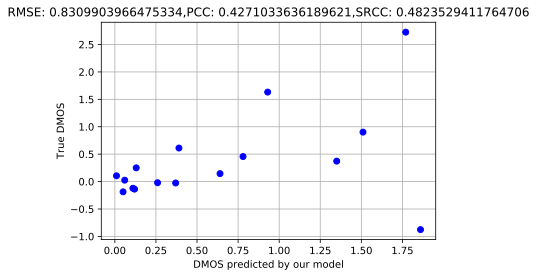

In [35]:
X_demo = df1.iloc[:16,0:28]
Y_demo = dmos.iloc[:16,2]
X_try = df1.iloc[16:,0:28]
Y_try = dmos.iloc[16:,2]
pca = PCA(n_components = 10)
lr = LinearRegression()
x_demo_mean, x_demo_std = X_demo.mean(), X_demo.std()
x_demo = (X_demo - x_demo_mean)/x_demo_std
x_test = (X_try - x_demo_mean)/x_demo_std
model = lr.fit(pca.fit_transform(x_demo), Y_demo)
pcr_predY = model.predict(pca.transform(x_test))
Y_try = np.array(Y_try)

plt.ylabel("True DMOS")
plt.xlabel('DMOS predicted by our model')
plt.plot(Y_try, pcr_predY,"bo")
pcr_rmse = np.sqrt(np.sum(np.square(pcr_predY - Y_try))/16)
pcr_pcc = stats.pearsonr(Y_try, pcr_predY)[0]
pcr_srcc = stats.spearmanr(Y_try, pcr_predY)[0]
plt.title('RMSE: {},PCC: {},SRCC: {}'.format(pcr_rmse,pcr_pcc,pcr_srcc))
plt.grid()
# plt.savefig("PCRmodel_component10.jpg")

## Comparison between both Results with varied n components

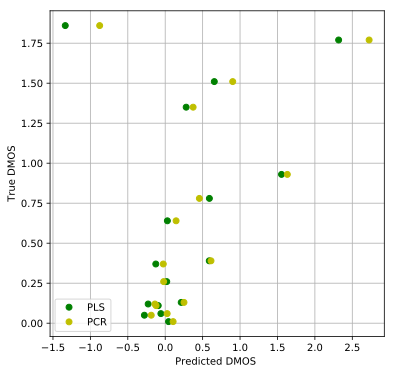

In [36]:
plt.figure(figsize=(6,6))
x = Y_try
plt.ylabel("True DMOS")
plt.xlabel('Predicted DMOS ')
l1, = plt.plot(pls_predY,Y_try,'go', linewidth=3.0)
l2, = plt.plot(pcr_predY,Y_try, 'yo', linewidth=3.0)
plt.legend(handles = [l1, l2,], labels = ['PLS', 'PCR'], loc = 'best')
plt.grid()
# plt.savefig("Comparision_model.jpg")

## Score Plot example

In [37]:
# eg_X = df1.iloc[:,0:28]
# eg_Y = dmos.iloc[:,2]
# [U, _, _] = np.linalg.svd(eg_X)
# # np.shape(U)
# plt.figure(figsize=(10, 10))
# plt.plot(U[:,0], U[:,1],'go-')
# for i in list(range(32)):
#     plt.annotate(i, (U[i,0]+.002, U[i,1]+.001))
    
# plt.xlabel("First Scores")
# plt.ylabel("Second Scores")
# plt.title("Scores Plot vs. DMOS")
# # plt.colorbar(orientation='horizontal')
# plt.show()

(32, 32)


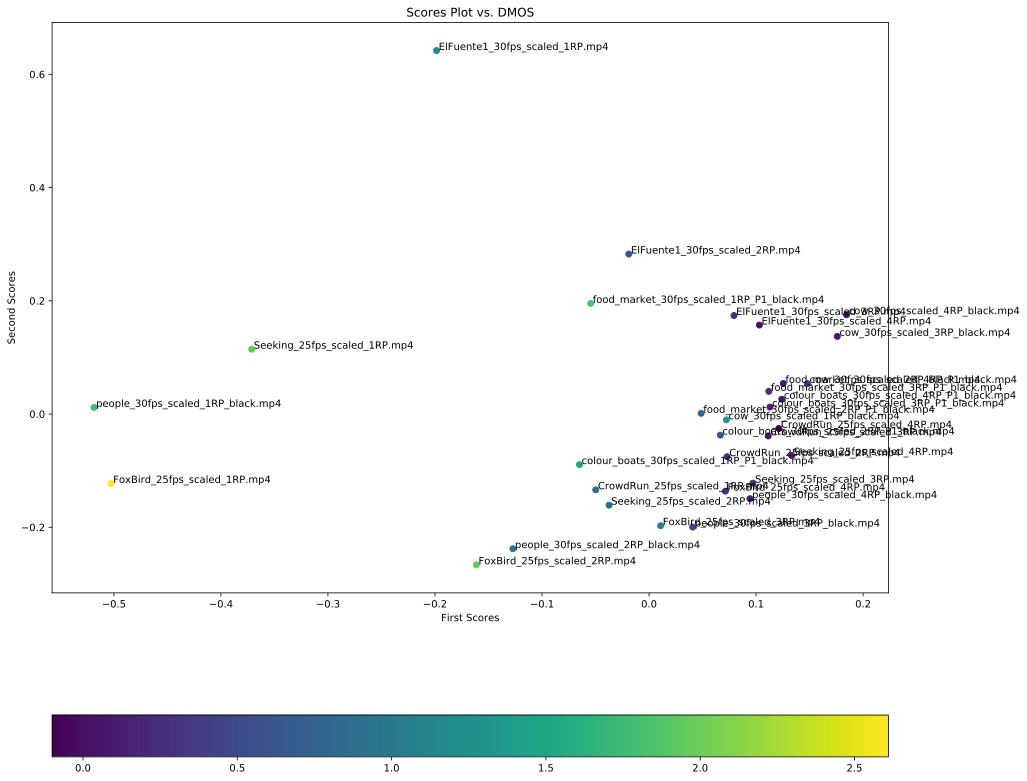

In [38]:
video_list = ['CrowdRun_25fps_scaled_1RP.mp4', 'CrowdRun_25fps_scaled_2RP.mp4', 'CrowdRun_25fps_scaled_3RP.mp4', 'CrowdRun_25fps_scaled_4RP.mp4',
           'ElFuente1_30fps_scaled_1RP.mp4', 'ElFuente1_30fps_scaled_2RP.mp4', 'ElFuente1_30fps_scaled_3RP.mp4','ElFuente1_30fps_scaled_4RP.mp4',
           'FoxBird_25fps_scaled_1RP.mp4', 'FoxBird_25fps_scaled_2RP.mp4', 'FoxBird_25fps_scaled_3RP.mp4', 'FoxBird_25fps_scaled_4RP.mp4',
           'Seeking_25fps_scaled_1RP.mp4', 'Seeking_25fps_scaled_2RP.mp4', 'Seeking_25fps_scaled_3RP.mp4', 'Seeking_25fps_scaled_4RP.mp4',
           'colour_boats_30fps_scaled_1RP_P1_black.mp4', 'colour_boats_30fps_scaled_2RP_P1_black.mp4', 'colour_boats_30fps_scaled_3RP_P1_black.mp4', 'colour_boats_30fps_scaled_4RP_P1_black.mp4',
           'cow_30fps_scaled_1RP_black.mp4', 'cow_30fps_scaled_2RP_black.mp4', 'cow_30fps_scaled_3RP_black.mp4', 'cow_30fps_scaled_4RP_black.mp4',
           'food_market_30fps_scaled_1RP_P1_black.mp4', 'food_market_30fps_scaled_2RP_P1_black.mp4', 'food_market_30fps_scaled_3RP_P1_black.mp4', 'food_market_30fps_scaled_4RP_P1_black.mp4',
           'people_30fps_scaled_1RP_black.mp4', 'people_30fps_scaled_2RP_black.mp4', 'people_30fps_scaled_3RP_black.mp4', 'people_30fps_scaled_4RP_black.mp4']


X = df1.iloc[:,0:28]
Y = dmos.iloc[:,2]
#X = df_use
[U, sigma, V] = np.linalg.svd(X)
print(U.shape)

plt.figure(figsize=(15, 15))

plt.scatter(U[:,0], U[:,1], c = Y, marker='o')
for i, txt in enumerate(video_list):
    plt.annotate(txt, (U[i,0]+.002, U[i,1]+.001))
    
plt.xlabel("First Scores")
plt.ylabel("Second Scores")
plt.title("Scores Plot vs. DMOS")
plt.colorbar(orientation='horizontal')
plt.show()